# Metropolis Hastings | Gibbs Sampling - T2

### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
df = pd.read_csv('Datos T2/ecl.dat', sep=' ')
df.head()

,a0,a1,b0,b1,f,id
0,0.029558,-0.016327,-0.104560,0.016127,3.927357,OGLE-GD-ECL-00001
1,0.061099,-0.055906,-0.038069,-0.005667,1.867562,OGLE-GD-ECL-00002
2,-0.014827,0.003208,0.082643,0.019817,0.358974,OGLE-GD-ECL-00003
3,0.167007,0.009713,0.023745,-0.018727,6.306853,OGLE-GD-ECL-00004
4,0.059108,-0.015537,-0.096507,0.003251,4.637037,OGLE-GD-ECL-00005


In [79]:
X = np.array(df[['a0', 'a1', 'b0', 'b1', 'f']])
y = np.array(df['id'])
y.shape

(43929,)

In [69]:
data = np.load('Datos T2/Params_ecl.npz')
lst = data.files
covs_0 = data['covs_0']
weights_0 = data['weights_0']
covs_1 = data['covs_1']
weights_1 = data['weights_1']

In [72]:
covs_0.shape, weights_0.shape

((2, 3, 3), (2,))

In [75]:
covs_0[0]

array([[ 2.78676236e-03,  9.26504739e-06, -2.44695139e-04],
       [ 9.26504739e-06,  2.75245753e-03, -2.38552171e-04],
       [-2.44695139e-04, -2.38552171e-04,  2.94306851e-01]])

## Metropolis Hastings

In [76]:
from scipy.stats import multivariate_normal

La idea es hacer para cada gaussiana que luego se mezcla, un metropolis-hasting para sus medias.

Antes de eso para evitar sobrecargar en el cálculo de la probabilidad del modelo dados los datos (pseudo _likelihood_) se filtran aleatoriamente los datos para utilizar una parte de ellos.

In [238]:
X_for_ll = X[np.random.randint(len(X), size=500)]

Una vez obtenido lo anterior se define P como la función que simula $P^*$. Se hace el cálculo con el supuesto de que no es necesario tener los datos de ambas gaussianas a mezclar sino que se puede hacer con cada gaussiana por separado. Lo anterior simplifica los cálculos y permite hacerlos más rápidamente. 

Por temas de _underflow_ se realiza un cálculo con la media de las probabilidades en vez del producto de ellas. Si bien esto no es válido, al ser tantos datos y tan bajas las probabilidades terminaba llegando a cero siempre. Puede ser "pseudo válido" si se interpreta como el promedio de las probabilidades de que cada dato provenga de un modelo con estas medias.

In [376]:
def P(means, covs, first_mixture=True):
    norm = multivariate_normal(means, covs)
    if first_mixture:
        data = X_for_ll[:,[0, 2, 4]]
    else:
        data = X_for_ll[:,[1, 3, 4]]
    return norm.pdf(data).mean()

In [377]:
def mh(covs, N, first_mixture=True):
    mus = [[0, 0, 2]]
    
    for _ in range(N):
        last_mus = mus[-1]

        Q_last = multivariate_normal(last_mus, covs)
        proposal = Q_last.rvs()
        Q_proposed = multivariate_normal(proposal, covs)

        Q_of_last_given_prop = Q_proposed.pdf(last_mus)
        Q_of_prop_given_last = Q_last.pdf(proposal)

        P_prop = P(proposal, covs, first_mixture=first_mixture)
        P_last = P(last_mus, covs, first_mixture=first_mixture)
        alpha = min(((Q_of_last_given_prop * P_prop) / (Q_of_prop_given_last * P_last)), 1)


        u = np.random.uniform(0, 1)
        if u < alpha:
            mus.append(proposal)
    return mus[1:]
            
def clean(array, burning, window):
    return np.array(array[burning::window])

In [393]:
# first gaussian of first mixture
mus_a = mh(covs_0[0], 10000)

In [394]:
# second gaussian of first mixture
mus_b = mh(covs_0[1], 10000)

In [425]:
len(mus_a), len(mus_b)

(6450, 5290)

In [396]:
burning = 500
window = 10
clean_mus_a = clean(mus_a, burning, window)
clean_mus_b = clean(mus_b, burning, window)
len(mus_a), len(clean_mus_a), len(mus_b), len(clean_mus_b)

(6450, 595, 5290, 479)

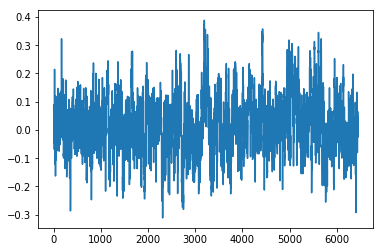

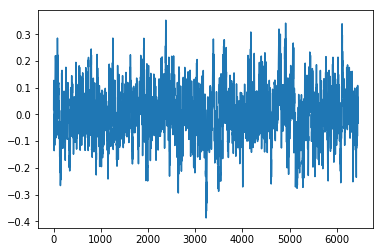

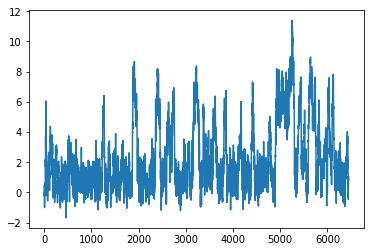

In [400]:
plt.plot(np.array(mus_a)[:, 0])
plt.show()
plt.plot(np.array(mus_a)[:, 1])
plt.show()
plt.plot(np.array(mus_a)[:, 2])
plt.show()

En los 3 gráficos anteriores se aprecia que si bien no hay una convergencia para los valores de las medias de la primera gaussiana de la primera mezcla, no se disparan demasiado lejos del rango esperado, y por ende luego, al promediarlos se puede teorizar que serán valores medianamente adecuados

In [401]:
candidate_mus_a = clean_mus_a.mean(axis=0)
candidate_mus_b = clean_mus_b.mean(axis=0)

In [407]:
candidate_mus_a, candidate_mus_b

(array([0.01642431, 0.00899219, 2.29012557]),
 array([2.01292252e-04, 1.71653872e-03, 2.17708554e+00]))

Con los datos anteriores se puede proceder a armar la primera mezcla de gaussianas

In [408]:
norm_a = multivariate_normal(candidate_mus_a, covs_0[0])
norm_b = multivariate_normal(candidate_mus_b, covs_0[1])
n_pdf = lambda x: weights_0[0] * norm_a.pdf(x) + weights_0[1] * norm_b.pdf(x)

In [423]:
n_pdf(X[0, [0, 2, 4]])

0.3668709142362286

Como se aprecia, una vez que se calcula la probabilidad del primer dato (a0, b0 y f de la primera fila), hace sentido en cuanto a que es alta siendo probable que dicho dato fuera generado por un modelo con dichas medias.

Ahora repitiendo el procedimiento para la segunda mezcla de gaussianas:

In [426]:
# first gaussian of second mixture
mus1_a = mh(covs_1[0], 10000)
# second gaussian of second mixture
mus1_b = mh(covs_1[1], 10000)

In [427]:
len(mus1_a), len(mus1_b)

(6224, 6553)

In [428]:
burning = 500
window = 10
clean_mus1_a = clean(mus1_a, burning, window)
clean_mus1_b = clean(mus1_b, burning, window)
len(mus1_a), len(clean_mus1_a), len(mus1_b), len(clean_mus1_b)

(6224, 573, 6553, 606)

In [429]:
candidate_mus1_a = clean_mus1_a.mean(axis=0)
candidate_mus1_b = clean_mus1_b.mean(axis=0)

In [430]:
candidate_mus1_a, candidate_mus1_b

(array([0.01204229, 0.00451727, 1.94462998]),
 array([ 0.00584972, -0.00808516,  1.61940652]))

In [431]:
norm1_a = multivariate_normal(candidate_mus1_a, covs_0[0])
norm1_b = multivariate_normal(candidate_mus1_b, covs_0[1])
n1_pdf = lambda x: weights_1[0] * norm1_a.pdf(x) + weights_1[1] * norm1_b.pdf(x)

In [435]:
n1_pdf(X[-1, [1, 3, 4]])

0.580169569153548

Tenemos entonces candidatos para nuestras gaussianas:

In [445]:
mus_0 = np.array((candidate_mus_a, candidate_mus_b))
mus_1 = np.array((candidate_mus1_a, candidate_mus1_b))

In [446]:
mus_0, mus_1

(array([[1.64243094e-02, 8.99218883e-03, 2.29012557e+00],
        [2.01292252e-04, 1.71653872e-03, 2.17708554e+00]]),
 array([[ 0.01204229,  0.00451727,  1.94462998],
        [ 0.00584972, -0.00808516,  1.61940652]]))

## Gibbs

Para esto hay que obtener expresiones para las condicionales de las mezclas de gaussianas. La intención es poder obtener expresiones para $P(a_i \mid b_i, f)$

Este problema se abordará marginalizando las normales multivariadas para cada mezcla y luego realizar la mezcla, es decir, se asume que si se marginaliza cada normal multivariada por separado y luego se hace la mezcla, se preservan las propiedades, equivalente a marginalizar la mezcla directamente.

Con lo anterior, para cada multivariada se requiere obtener expresiones para $P(a_i \mid b_i, f)$, $P(b_i \mid a_i, f)$ y $P(f \mid a_i, b_i)$. Con $i$ el índice de la mezcla, 0 o 1.

Un esquema general para el _sampling_ es el siguiente, donde posteriormente se definiran las expresiones condicionadas.

In [588]:
def gibbs(a_given_bf, b_given_af, f_given_ab, N, x0):
    samples_a = np.zeros(N + 1)
    samples_b = np.zeros(N + 1)
    samples_f = np.zeros(N + 1)
    samples_a[0] = x0[0]
    samples_f[0] = f_given_ab(x0[0], x0[1])
    samples_b[0] = b_given_af(x0[0], samples_f[0])
    for i in range(1, N + 1):
        samples_a[i] = a_given_bf(samples_b[i - 1], samples_f[i - 1])
        samples_b[i] = b_given_af(samples_a[i - 1], samples_f[i - 1])
        samples_f[i] = f_given_ab(samples_a[i - 1], samples_b[i - 1])
    return samples_a, samples_b, samples_f

In [523]:
from scipy.stats import norm

La intención es ser capaz de condicionar para cada caso, como son normales multivariadas existe una forma analítica de condicionar, y para eso el condicionamiento considera operar sobre la matriz de covarianza particionándola de modo que se pueda operar con ella en 4 submatrices, una conteniendo el parámetro no condicionado, otra los condicionados y otras dos únicamente covarianzas (son iguales por la simetría).

Lo anterior a partir de lo mencionado [aquí](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions), [aquí](https://math.stackexchange.com/questions/506129/multivariate-normal-distribution-conditional-on-two-random-variables) y [aquí](https://peterroelants.github.io/posts/multivariate-normal-primer/), más lo visto en clases.

El cálculo de la media es más complejo y se explica en esos documentos, pero el de la covarianza es así: lo que se hace es tomar la matriz de covarianzas, invertirla, eliminar las filas y columnas que hacen referencia a los parámetros condicionados y volver a invertir la matriz.

En un primer caso se hará para $a_i$ dado los otros 2 parámetros, pero el procedimiento es análogo para $b_i$ y $f$.

In [531]:
def a_given_bf(b, f, mus, covs):
    ma = mus[0][0] 
    mb = mus[0][1]
    mf = mus[0][2]

    c11 = covs[0][0:1, 0:1]
    c12 = covs[0][0:1, 1:3]
    c22 = covs[0][1:3, 1:3]
    mu_a = ma + c12.dot(np.linalg.inv(c22)).dot(([b, f] - np.array([mb, mf])).T).T
    std_a = np.linalg.inv(np.linalg.inv(covs[0])[:1,:1])
    
    ma = mus[1][0] 
    mb = mus[1][1]
    mf = mus[1][2]
    
    c11 = covs[1][0:1, 0:1]
    c12 = covs[1][0:1, 1:3]
    c22 = covs[1][1:3, 1:3]
    mu_b = ma + c12.dot(np.linalg.inv(c22)).dot(([b, f] - np.array([mb, mf])).T).T
    std_b = np.linalg.inv(np.linalg.inv(covs[1])[:1,:1])
    
    norm_a = norm(mu_a, std_a).rvs()
    norm_b = norm(mu_b, std_b).rvs()
    
    return np.random.choice([norm_a, norm_b], p=weights_0)

Notar que al final se elige aleatoriamente entre las dos normales. Lo anterior porque si bien para obtener la PDF de una mezcla de normales es necesario ponderar por los pesos, para muestrar a partir de una lo que se hace es hacer un _weighted_random_ entre muestras de cada normal previo a mezclar, es decir, elegir aleatoriamente con pesos. Siendo justamente dichos pesos, los pesos de las multivariadas que se usan para la mezcla.

In [533]:
a_given_bf(0, 1.88, mus_0, covs_0)

0.01549636360024905

In [534]:
a0_given_b0f = lambda b, f: a_given_bf(b, f, mus_0, covs_0)
a1_given_b1f = lambda b, f: a_given_bf(b, f, mus_1, covs_1)

Análogamente para $b_i$ y para $f$:

In [563]:
def b_given_af(a, f, mus, covs):
    ma = mus[0][0] 
    mb = mus[0][1]
    mf = mus[0][2]

    c11 = covs[0][1:2, 1:2]
    c12 = covs[0][[0, 2], [1, 1]]
    c22 = covs[0][0:3:2, 0:3:2]
    mu_a = mb + c12.dot(np.linalg.inv(c22)).dot(([a, f] - np.array([ma, mf])).T).T
    std_a = np.linalg.inv(np.linalg.inv(covs[0])[1:2,1:2])
    
    ma = mus[1][0] 
    mb = mus[1][1]
    mf = mus[1][2]
    
    c11 = covs[1][1:2, 1:2]
    c12 = covs[1][[0, 2], [1, 1]]
    c22 = covs[1][0:3:2, 0:3:2]
    mu_b = mb + c12.dot(np.linalg.inv(c22)).dot(([a, f] - np.array([ma, mf])).T).T
    std_b = np.linalg.inv(np.linalg.inv(covs[1])[1:2,1:2])
    
    norm_a = norm(mu_a, std_a).rvs()
    norm_b = norm(mu_b, std_b).rvs()
    
    return np.random.choice([norm_a, norm_b], p=weights_0)

In [564]:
b_given_af(0, 1.88, mus_0, covs_0)

0.009876254501849441

In [565]:
b0_given_a0f = lambda a, f: b_given_af(a, f, mus_0, covs_0)
b1_given_a1f = lambda a, f: b_given_af(a, f, mus_1, covs_1)

In [577]:
def f_given_ab(a, b, mus, covs):
    ma = mus[0][0] 
    mb = mus[0][1]
    mf = mus[0][2]

    c11 = covs[0][2:3, 2:3]
    c12 = covs[0][2:3, 0:2]
    c22 = covs[0][0:2, 0:2]
    mu_a = mf + c12.dot(np.linalg.inv(c22)).dot(([a, b] - np.array([ma, mb])).T).T
    std_a = np.linalg.inv(np.linalg.inv(covs[0])[2:3,2:3])
    
    ma = mus[1][0] 
    mb = mus[1][1]
    mf = mus[1][2]
    
    c11 = covs[1][0:1, 0:1]
    c12 = covs[1][2:3, 0:2]
    c22 = covs[1][0:2, 0:2]
    mu_b = mf + c12.dot(np.linalg.inv(c22)).dot(([a, b] - np.array([ma, mb])).T).T
    std_b = np.linalg.inv(np.linalg.inv(covs[1])[2:3,2:3])
    
    norm_a = norm(mu_a, std_a).rvs()
    norm_b = norm(mu_b, std_b).rvs()
    
    return np.random.choice([norm_a, norm_b], p=weights_0)

In [582]:
f_given_ab(0, 0.01, mus_0, covs_0)

2.112850438620913

In [613]:
f_given_a0b0 = lambda a, b: f_given_ab(a, b, mus_0, covs_0)
f_given_a1b1 = lambda a, b: f_given_ab(a, b, mus_1, covs_1)

Una vez obtenidas todas las expresiones para las condicionales de cada parámetro respecto a los restantes, se puede proceder

Como punto de partida para la primera mezcla de gaussianas multivariadas tomaré x0 y x1 para la segunda

In [586]:
x0 = X[np.random.randint(len(X))][[0, 2]]  # valores de a0 y b0
x1 = X[np.random.randint(len(X))][[1, 3]]  # valores de a1 y b1

In [599]:
N = 1000
all_samples0 = gibbs(a0_given_b0f, b0_given_a0f, f_given_a0b0, N, x0)

In [614]:
all_samples1 = gibbs(a1_given_b1f, b1_given_a1f, f_given_a1b1, N, x1)

In [615]:
samples_a0, samples_b0, samples_f0 = all_samples0
samples_a1, samples_b1, samples_f1 = all_samples1

In [666]:
# the x0 is not used
samples_a0_ = samples_a0[1:] 
samples_b0_ = samples_b0[1:]
samples_f0_ = samples_f0[:-1]

samples_a1_ = samples_a1[1:] 
samples_b1_ = samples_b1[1:]
samples_f1_ = samples_f1[:-1]

Realizo un proceso de limpieza similar al de el método anterior

In [617]:
burning = 50
window = 5
clean_samples_a0 = clean(samples_a0_, burning, window)
clean_samples_b0 = clean(samples_b0_, burning, window)
clean_samples_f0 = clean(samples_f0_, burning, window)

clean_samples_a1 = clean(samples_a1_, burning, window)
clean_samples_b1 = clean(samples_b1_, burning, window)
clean_samples_f1 = clean(samples_f1_, burning, window)

Ahora como ya está limpio, puedo proceder a, utilizando lo entregado en el enunciado, graficar la serie

In [668]:
x = lambda t, S: np.sum([S[i] * np.sin(2 * np.pi * (i + 1) * S[4] * t) + 
                         S[2 + i] * np.cos(2 * np.pi * (i + 1) * S[4] * t) for i in range(2)])

En adelante utilizo solo el $f$ generado por la primera parte, es decir el de la primera mezcla, pero podría utilizarse indistintamente cualquiera de los dos

In [669]:
sampled_data = np.column_stack(
    (clean_samples_a0, clean_samples_a1, clean_samples_b0, clean_samples_b1, clean_samples_f0)
)

In [672]:
serie = sampled_data[np.random.randint(len(sampled_data))]
dots = [x(i, serie) for i in range(100)]

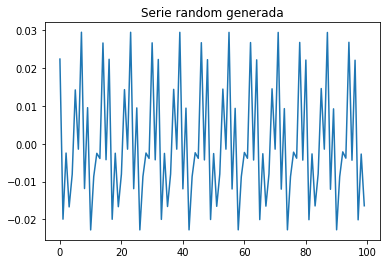

In [676]:
plt.title('Serie random generada')
plt.plot(range(100), dots)
plt.show()

In [677]:
original_serie = X[np.random.randint(len(X))]
original_dots = [x(i, original_serie) for i in range(100)]

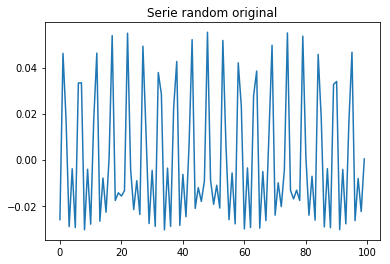

In [678]:
plt.plot(range(100), original_dots)
plt.title('Serie random original')
plt.show()

No alcancé a hacer un análisis acabado ni el comentario final, pero creo que tras experimentar profundamente con los métodos en cuestión el pie está dado para hacer el análisis de las frecuencias pedidos. Perdón por no terminar.